<a href="https://colab.research.google.com/github/davinhill/BivariateShapley/blob/main/Examples/example_sentimentanalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example: Explain a Sentiment Analysis classifier

In sentiment analysis we take text samples as input and predict whether the sample exhibits positive or negative sentiment. After training our classifier we are interesting in understand which words are important with respect to the prediction as well as directional interactions between the words. In this example, we apply Bivariate Shapley to a pre-trained transformer from [HuggingFace](https://huggingface.co) [1].

In [23]:
%%capture

# Download additional packages if using Google Colab

try:
    import google.colab # check if using Google Colab

    !apt install libgraphviz-dev
    !pip install transformers shap scikit-network networkx pygraphviz
    !git clone https://github.com/davinhill/BivariateShapley.git

    import sys
    sys.path.append('./BivariateShapley')

except:
    pass

In [24]:
# Import packages

import transformers
from transformers import BertTokenizerFast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from IPython.display import Image

from BivariateShapley.utils_shapley import *
from BivariateShapley.shapley_kernel import Bivariate_KernelExplainer



# Prepare Model, Data, and Explainer

We need 3 things to to run Bivariate Shapley:
1. A Utility Function to evaluate
2. A Data sample to explain
3. Specified Reference Values


<br />


1) The **Utility Function** is some function $u:\mathbb{R}^d \rightarrow \mathbb{R}$ that takes the d-dimensional data samples as input and returns a score. In our context, this is the output of the transformer model. Since the Bivariate Shapley explainer expects a vectorized data samples instead of text, we can code a wrapper function eval_transformer() includes a tokenization step. The "score" for our model is the predicted probability of positive sentiment.


<br />


2) The **Data sample** is the d-dimensional test sample that we wish to explain.


<br />


3) In addition, since we are using a feature removal method, we need to specify the **reference values** that are used to represent "removed" features (see [Covert et al](https://arxiv.org/abs/2011.03623) [2] section 4.2 for a good overview). These reference values should be drawn from some non-informative reference distribution; most Shapley methods specify the use of training samples to represent the training distribution.

In our case, we can set these reference values to the token value 103 which represents a masked value in the bert-base-cased tokenizer.

In [25]:

# download sentiment analysis model from huggingface
model = transformers.pipeline('sentiment-analysis')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')


# define utility function wrapper for the huggingface model
# utility function takes input as x, and returns a score
class eval_transformer():
    def __init__(self, model, tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased'), **kwargs):
        self.model = model
        #self.baseline = None
        self.tokenizer = tokenizer

    def __call__(self, x, **kwargs):

        n = x.shape[0]
        x = x.astype(dtype = 'int')
        x = x.tolist()
        x_tkn = self.tokenizer.batch_decode(x)
        output = self.model(x_tkn)
        score = []
        for i in range(n):
            score.append(output[i]['score'])
        score = np.array(score)
        return score

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


# Explain Data Sample
Here is the phrase that we want to predict / explain:

In [26]:
x = 'this table is ugly and hideous'

Now we can initialize the explainer. The Bivariate Shapley-K method (BivShap-K) takes advantage of the KernelSHAP algorithm which is implemented in the excellent and well-documented [SHAP](https://github.com/slundberg/shap) package [3]. KernelSHAP is a model-agnostic explanation method used to approximate (univariate) SHAP values.

BivShap-K uses a number of tricks from KernelSHAP to speed up the Bivariate Shapley approximation. Since BivShap-K is built on top of KernelSHAP, the Bivariate_KernelExplainer class takes many of the same arguments as [shap.KernelExplainer](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.KernelExplainer.html).

In [27]:
value_function = eval_transformer(model) # initialize the value function
x_tkn = np.array(encode(x)).reshape(1,-1) # tokenize the input sentence
x_train = np.zeros_like(x_tkn) + 103 # define the reference values to be token 103
explainer = Bivariate_KernelExplainer(value_function, x_train) # initialize BivShap-K


# Explain Sample
uni_shapley = explainer.shap_values(x_tkn, l1_reg = False) # univariate shapley values
biv_shapley_G = explainer.phi_b # bivariate shapley values



  0%|          | 0/1 [00:00<?, ?it/s]

Running Bivariate_KernelExplainer calculates both Univariate Shapley (SHAP) and Bivariate Shapley values simultaneously. Let's visualize the calculated Shapley values in a heatmap:

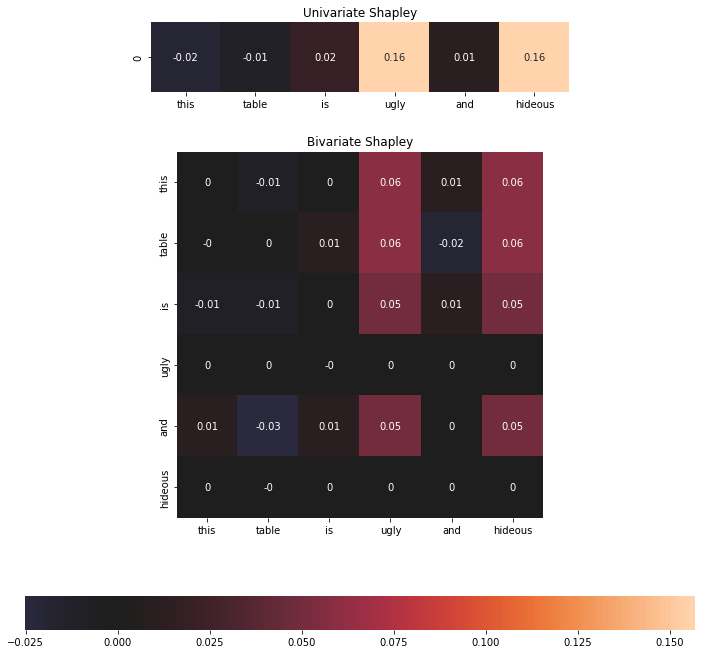

In [28]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12), sharey=False, sharex = False, gridspec_kw={'height_ratios':[4,30]})
node_labels = tokenizer.batch_decode(tokenizer.encode(x, add_special_tokens = False))
annot_flag = True

min_value = min(uni_shapley.min(), biv_shapley_G.min())
max_value = max(uni_shapley.max(), biv_shapley_G.max())

# univariate =======================
tmp = pd.DataFrame(uni_shapley.reshape(1, -1).round(2))
tmp.columns = node_labels
#tmp = tmp.transpose()
sns.heatmap(tmp, square=True, annot = annot_flag, center = 0,cbar_kws = dict(use_gridspec=False,location="bottom"), ax = axes[0], vmin = min_value, vmax = max_value, cbar = False)

# bivariate =======================
tmp = pd.DataFrame(biv_shapley_G.round(2))
tmp.columns = node_labels
tmp.index = node_labels

sns.heatmap(tmp, square=True, annot = annot_flag, center = 0,cbar_kws = dict(use_gridspec=False,location="bottom"), ax = axes[1], vmin = min_value, vmax = max_value)

axes[0].set_title('Univariate Shapley')
axes[1].set_title('Bivariate Shapley')
plt.show()

## Understanding the Bivariate Shapley Formulation

Recall the utility function formulation for Bivariate Shapley (Eq. 5 in the paper):

$$ u_{i}: P(D) \to \mathbb{R} \quad \text{s.t.} \quad \, \forall S\in P(D),\, u_{i}(S) = \begin{cases} 
u(S), &\text{if}~i\in S, \\
0, &\text{if}~i\notin S.
\end{cases}$$

Where $u_i$ is the utility function for feature $i$, $P(D)$ is the power set for $D$ features, $S$ is the subset of features selected by the Shapley calculation. Note that we have $D$ utility functions, and we apply each utility function to $D$ features, which results in a $D\times D$ matrix. Each element of this matrix represents a directional interaction between the row and column features.

<br />

The intuition behind this formulation is that we are "filtering" the utility function from the standard univariate Shapley calculation. Whenever the selected subset of features $S$ *does not* includes feature $i$ (i.e. feature $i$ is already "removed"), then the utility function is set to 0. Each feature $i$ represents a separate column in the $D \times D$ Bivariate Shapley matrix. Therefore we can think of each column of the Bivariate Shapley matrix as a separate Univariate Shapley calculation; each being "filtered" with respect to a different feature.

<br />

##Interpreting the Bivariate Shapley Matrix

We can think of each row $j$ of the Bivariate Shapley Matrix as the Shapley value for feature $j$ conditioned on the column feature $i$ being "present" in the Shapley calculation.

If an element $(j,i)$ of the matrix has **low value**, this indicates that feature $j$ is relatively unimportant (low Shapley value) when feature $i$ is present. This suggests that when the black-box model has information from feature $i$, it no longer needs feature $j$, therefore the Bivariate Shapley value is low.

Conversely, if element $(j,i)$ of the matrix has **high value**, this suggests that having feature $i$ has little effect on the importance of feature $j$.

<br />

In our example above, we see that the word "hideous" has high univariate Shapley value, indicating that is an important feature. However, the Bivariate Shapley value for (Hideous, Ugly) is 0, which indicates that when the model has the word "Ugly" in the input, the word "Hideous" becomes unimportant; i.e. it is redundant.


---



# The $\mathcal{G}$-graph


Another way to interpret the Bivariate Shapley Matrix is as an adjacency matrix of a weighted, directed graph. The direction of the edges $i \rightarrow j$ indicates feature importance value of $j$ given that feature $i$ is present.

<br />

Below we can visualize this graph using [NetworkX](https://networkx.org) and [Pygraphviz](https://pygraphviz.github.io). Note that this plot can take a while to generate if you are trying to plot a large number of features.

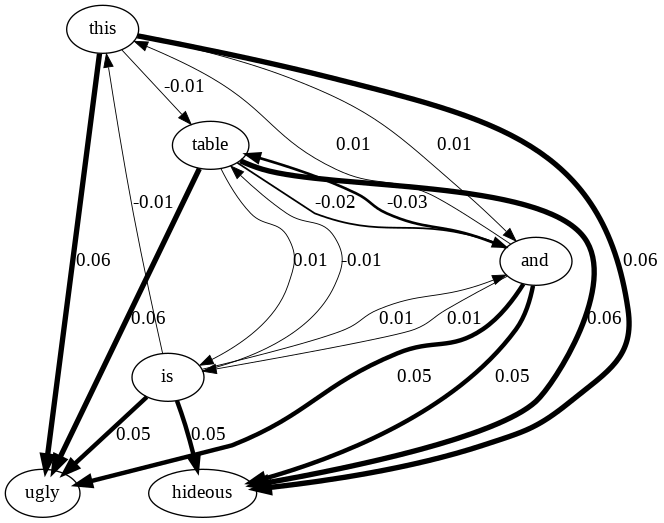

In [29]:
plot_graph(biv_shapley_G.round(2), node_labels, save_path = './graph.png', label_edge_weights = True)
Image(filename='graph.png') 

## Top Influential Features on $\mathcal{G}$

As well as being a nice visualization tool, the graph interpretation of Bivariate Shapley allows us to identify a number of key properties within the feature interactions. In particular, note that highly-weighted edges indicate that the head feature retains high Shapley value even when the tail feature is present. This suggests that the sinks of the $\mathcal{G}$-graph (we call these $\mathcal{G}$-sinks) represent the features that carry the most information with respect to the prediction; i.e. these are the features that retain high Shapley values in the presence of other features. 

<br />

While we could simply consider the $\mathcal{G}$-sinks as a group of influential features, in many applications it's preferable to have a continuous ranking of the features. We can do this using the PageRank [4] algorithm, which gives an estimate of each feature's "sinkness". Therefore this gives us a ranking of features based on how much information a feature provides to the prediction

In [30]:
scores = calc_PR_scores(biv_shapley_G, personalize = True, shapley_values = uni_shapley.reshape(-1))


print("Feature Ranking, in descending order of influence (most important first):")
score_tbl = pd.DataFrame(np.concatenate((np.array(node_labels).reshape(-1,1), scores.reshape(-1,1)), axis = 1), columns = ['feature', 'score'])
score_tbl.sort_values(by='score', ascending = False)

Feature Ranking, in descending order of influence (most important first):


,feature,score
3,ugly,0.21992620840461596
5,hideous,0.21978174998724131
2,is,0.15065844278392104
4,and,0.14319611878893215
1,table,0.13379889753276888
0,this,0.13263858250252072




---


# The $\mathcal{H}$-graph

Another aspect of feature interactions we might be interested in are feature redundancies; i.e. the situation where the Shapley value of feature $j$ becomes zero when feature $i$ is present. These relationships are captured by the zero-weight edges in the $\mathcal{G}$-graph. In order to further explore the feature redundancy patterns, we therefore define the unweighted, directed $\mathcal{H}$-graph.

<br />


The $\mathcal{H}$-graph is defined to have an unweighted edge for every zero-weight edge in the $\mathcal{G}$. Therefore each edge $i \rightarrow j$ indicates that feature $i$ makes feature $j$ redundant.

<br />

Due to the sampling error from Shapley value estimation, in practice we use a parameter $\gamma >0$ as a threshold for converting zero-weight edges in $\mathcal{G}$ to edges in $\mathcal{H}$

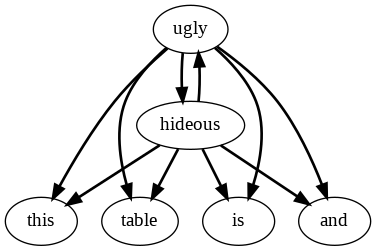

In [31]:
gamma = 1e-3
biv_shapley_H = g2h(biv_shapley_G, gamma)

plot_graph(biv_shapley_H.round(2), node_labels, directed = True, save_path = './graph.png', edge_width = 2)
Image(filename='graph.png') 

## Identifying Mutually Redundant Features on $\mathcal{H}$

When two features simultaneously make the other redundant, we define these two features as **Mutually Redundant**. More concretely:

<br />

Given $i,j\in D$, features $i,j$ are *mutually redundant* if $E^{2}(u)_{ij} = E^{2}(u)_{ji} =  0$.

<br />


Where $E^2$ is the Bivariate Shapley Matrix. In the $\mathcal{H}$-graph, mutually redundant features can be identified as [strongly-connected components](https://en.wikipedia.org/wiki/Strongly_connected_component). In our example, the words "ugly" and "hideous" form a strongly connected component. Intuitively, this indicates that these two words are interchangeable; i.e. if the transformer model has only one of these words, it captures all the information provided by the other word (and vice-versa).

In [32]:
MR = find_MR(biv_shapley_H) # provide the H-graph adjacency matrix to identify Mutually Redundant features

# print identified clusters
for cluster in MR:
    print(np.array(node_labels)[cluster].tolist())

['ugly', 'hideous']


## Identifying Directionally Redundant Features on $\mathcal{H}$

In contrast to Mutually Redundant features, Directionally Redundant features only exhibit redundancy in one direction. In our example, the word "hideous" makes the words "this", "table", "is", and "and" redundant. This redundancy can be identified as the $\mathcal{H}$-sink nodes in the $\mathcal{H}$-graph.



In [33]:
DR_source, DR_sink, _ = find_DR(biv_shapley_H) # identify source / sink clusters


# print identified clusters
print('Sink Clusters; Directionally Redundant features')
print_DR_clusters(DR_sink, node_labels)

print('')
print('Source Clusters')
print_DR_clusters(DR_source, node_labels)


Sink Clusters; Directionally Redundant features
['this', 'table', 'is', 'and']
['this']
['table']
['is']
['and']

Source Clusters
['ugly', 'hideous']
['ugly', 'hideous']


---

# References
<a id='references'></a>

[1] Wolf, T., Debut, L., Sanh, V., Chaumond, J., Delangue, C., Moi, A., Cistac, P., Rault, T., Louf, R., Funtowicz, M., Davison, J., Shleifer, S., von Platen, P., Ma, C., Jernite, Y., Plu, J., Xu, C., Scao, T. L., Gugger, S., … Rush, A. M. (2020). Transformers: State-of-the-art natural language processing. Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing: System Demonstrations, 38–45. https://www.aclweb.org/anthology/2020.emnlp-demos.6

<br />

[2] Covert, I., Lundberg, S., & Lee, S.-I. (2020). Feature Removal Is a Unifying Principle for Model Explanation Methods. ArXiv:2011.03623 [Cs, Stat]. http://arxiv.org/abs/2011.03623

<br />

[3] Lundberg, S. M., & Lee, S.-I. (2017). A unified approach to interpreting model predictions. In I. Guyon, U. V. Luxburg, S. Bengio, H. Wallach, R. Fergus, S. Vishwanathan, & R. Garnett (Eds.), Advances in neural information processing systems 30 (pp. 4765–4774). Curran Associates, Inc. http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf

<br />

[4] Page, L., Brin, S., Motwani, R. & Winograd, T. (1998). The PageRank citation ranking: Bringing order to the Web. Proceedings of the 7th International World Wide Web Conference (p./pp. 161--172), Brisbane, Australia. 

